## **Appendix A - Spatially-Dependent Reliable Shortest Path Problem Hierarchial A* algorithm**

**Course:** AER1516 - Motion Planning for Robotics

**Due:** 22 April 2022

**Team:** Vishal Kanna Annand, Andrew Constantinescu, Sugumar Prabhakaran

### **Introduction**

This algorithm implementation solves the spatially-dependent reliable shortest path problem. This is accomplished by constructing a two-level hierarchy network used to compare the dominance between all paths.  Please see Section 4 of our paper for details on the implementation.

In [1]:
# Import necessary modules
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import networkx as nx
import bisect

In [2]:
# Build a primal network and draw it for visualization
def construct_road_network(index):
  if index != 0 and index != 1 and index != 2:
    return -1

  if index == 0:
    road_network = nx.DiGraph()
    road_network.add_node((1,), x=0, y=0)
    road_network.add_node((2,), x=1, y=1)
    road_network.add_node((3,), x=1, y=0)
    road_network.add_node((4,), x=1, y=-1)
    road_network.add_node((5,), x=2, y=0)
    road_network.add_node((6,), x=3, y=0)
    road_network.add_node((7,), x=3, y=1)
    road_network.add_node((8,), x=3, y=2)
    road_network.add_node((9,), x=1, y=2)
    road_network.add_edge((1,), (2,), cov_key=0, weight=2)
    road_network.add_edge((1,), (3,), cov_key=1, weight=5)
    road_network.add_edge((1,), (4,), cov_key=2, weight=3)
    road_network.add_edge((2,), (5,), cov_key=3, weight=1)
    road_network.add_edge((3,), (5,), cov_key=4, weight=1)
    road_network.add_edge((4,), (5,), cov_key=5, weight=1)
    road_network.add_edge((5,), (6,), cov_key=6, weight=1)
    road_network.add_edge((6,), (7,), cov_key=7, weight=1)
    road_network.add_edge((7,), (8,), cov_key=8, weight=1)
    road_network.add_edge((9,), (2,), cov_key=9, weight=1)
    road_network_cov = np.asarray([[10, 0.5, -0.5, 0, 0, 0, 0, 0, 0, 0],
                                  [0.5, 0.1, 1.2, 0, 0, 0, 0, 0, 0, 0],
                                  [-0.5, 1.2, 40, 0, 0, 0, 0, 0, 0, 0],
                                  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
  if index == 1:
    road_network = nx.DiGraph()
    road_network.add_node((1,), x=0, y=0)
    road_network.add_node((2,), x=1, y=1)
    road_network.add_node((3,), x=1, y=0)
    road_network.add_node((4,), x=1, y=-1)
    road_network.add_node((5,), x=2, y=0)
    road_network.add_edge((1,), (2,), weight=2, cov_key=0)
    road_network.add_edge((1,), (3,), weight=3, cov_key=1)
    road_network.add_edge((1,), (4,), weight=4, cov_key=2)
    road_network.add_edge((2,), (3,), weight=2, cov_key=3)
    road_network.add_edge((3,), (5,), weight=4, cov_key=4)
    road_network.add_edge((4,), (5,), weight=4, cov_key=5)
    road_network_cov = np.asarray([[2, -1, -1, 2, 0.3, -0.2],
                                   [-1, 1, -0.5, -1, 1.5, -0.6],
                                   [-1, -0.5, 1, -0.3, -0.4, 0.5],
                                   [2, -1, -0.3, 2, 2, -0.4],
                                   [0.3, 1.5, -0.4, 2, 6, -1.5],
                                   [-0.2, -0.6, 0.5, -0.4, -1.5, 1]])
    
  if index == 2:
    road_network = nx.DiGraph()
    road_network.add_node((1,), x=1, y=3)
    road_network.add_node((2,), x=3, y=4)
    road_network.add_node((3,), x=3, y=3)
    road_network.add_node((4,), x=3, y=2)
    road_network.add_node((5,), x=5, y=4.5)
    road_network.add_node((6,), x=5, y=3.5)
    road_network.add_node((7,), x=5, y=2)
    road_network.add_node((8,), x=7, y=4)
    road_network.add_node((9,), x=7, y=2)
    road_network.add_node((10,), x=9, y=4)
    road_network.add_node((11,), x=9, y=2)
    road_network.add_node((12,), x=11, y=4)
    road_network.add_node((13,), x=11, y=2)
    road_network.add_node((14,), x=13, y=3)
    road_network.add_edge((1,), (2,), cov_key=0, weight=3)
    road_network.add_edge((1,), (3,), cov_key=1, weight=1)
    road_network.add_edge((1,), (4,), cov_key=2, weight=1)
    road_network.add_edge((2,), (5,), cov_key=3, weight=2)
    road_network.add_edge((2,), (6,), cov_key=4, weight=3)
    road_network.add_edge((3,), (5,), cov_key=5, weight=2)
    road_network.add_edge((3,), (6,), cov_key=6, weight=7)
    road_network.add_edge((3,), (7,), cov_key=7, weight=1)
    road_network.add_edge((4,), (6,), cov_key=8, weight=7)
    road_network.add_edge((4,), (7,), cov_key=9, weight=3)
    road_network.add_edge((5,), (8,), cov_key=10, weight=5)
    road_network.add_edge((6,), (9,), cov_key=11, weight=1)
    road_network.add_edge((7,), (9,), cov_key=12, weight=6)
    road_network.add_edge((8,), (10,), cov_key=13, weight=4)
    road_network.add_edge((9,), (11,), cov_key=14, weight=2)
    road_network.add_edge((11,), (10,), cov_key=15, weight=2)
    road_network.add_edge((10,), (12,), cov_key=16, weight=1)
    road_network.add_edge((10,), (13,), cov_key=17, weight=2)
    road_network.add_edge((11,), (13,), cov_key=18, weight=1)
    road_network.add_edge((12,), (14,), cov_key=19, weight=1)
    road_network.add_edge((13,), (14,), cov_key=20, weight=4)
    road_network_cov = np.asarray([[  2,   1,   2,   0,   0,   0,   0,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  1, 0.1,   2,   0,   0,   0,   0,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  1,   2,   6,   0,   0,   0,   0,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0, 0.5,   0,   0,   0,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   2,   0,   0,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0, 0.2,   0,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   1,   0,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0, 0.1,   2,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  2,   2,   2,   2,   2,   2,   2,   2,   9,   0,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   9,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   2,   0,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,    0,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  0.7,   0,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   1,   0,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   2,   0,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   1,   0,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   1,   0,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0, 0.5,   0,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0, 0.2,   0,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   1,   0],
                                   [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,    0,   0,   0,   0,   0,   0,   0,   0, 0.1]])
  # draw network
  positions = {i:[road_network.nodes[i]['x'],road_network.nodes[i]['y']] for i in list(road_network.nodes)}
  t_ij = {(i, j):road_network.edges[(i,j)]['weight'] for (i,j) in list(road_network.edges)}
  nx.draw_networkx(road_network, positions, with_labels=True, font_color='white', node_size=600)
  nx.draw_networkx_edge_labels(road_network, pos=positions, edge_labels=t_ij)
  plt.show()
  return road_network, road_network_cov

In [3]:
# Helper function for debugging
def print_ground_hierarchy(Hg):
  for tree in Hg:
    print(tree.adj)

# Construct the ground hierarchy network
def build_Hg(G, k=3, draw_Hg=False):
  Hg = []
  for n in G.nodes:
    Hg_n = nx.DiGraph()
    Hg_n.add_node(n)
    
    parents = [n]
    for i in range(1, k):
      next_parents = []
      for p in parents:
        p_number = (p[-1],)
        children = list(G.successors(p_number))
        for c in children:
          n2 = p + c
          Hg_n.add_edge(n2, p)
          next_parents.append(n2)
      parents = next_parents

    Hg.append(Hg_n)
    if draw_Hg == True:
      nx.draw(Hg[0], with_labels=True, font_color='white', node_size=3000)
      # print_ground_hierarchy(Hg[0])
  return Hg

In [4]:
# Function that takes as input a directed-in-tree from the ground hierarchy Hg and returns all the border nodes, which are to be used as the nodes in the top hierarchy Ht
def get_border_nodes(tree, k=3):
  border_nodes = []
  for in_deg_node in tree.in_degree:
    node = in_deg_node[0]
    num_in_nodes = in_deg_node[1]
    if num_in_nodes == 0 and len(nx.descendants_at_distance(tree, node, k-1)) == 1:
      border_nodes.append(node)
  return border_nodes

# Construct the top hierarchy network
def build_Ht(G, Hg, k=3, draw_Ht=False):
  if k == 1:
    return G
  Ht = nx.DiGraph()
  nodes = []
  for tree in Hg:
    nodes = nodes + get_border_nodes(tree, k)   # create list of all the border nodes from all the trees in the ground hierarchy Hg
  Ht.add_nodes_from(nodes)
  for node_i in Ht.nodes:
    for node_j in Ht.nodes:
      if (node_i[1:] == node_j[0:-1]):
        Ht.add_edge(node_i, node_j)
  if draw_Ht == True:
    positions = {(1,2,5):[1,8], (1,3,5):[3,8], (1,2,6):[5,8], (1,3,6):[7,8], (1,4,6):[9,8], (1,3,7):[11,8], (1,4,7):[13,8], (2,5,8):[1,6], (3,5,8):[3,6],
                 (2,6,9):[5,6], (3,6,9):[7,6], (4,6,9):[9,6], (3,7,9):[11,6], (4,7,9):[13,6], (6,9,11):[5,4], (7,9,11):[12,4], (5,8,10):[2,2], (9,11,10):[5,2],
                 (9,11,13):[12,2], (8,10,12):[1,0], (11,10,12):[3,0], (8,10,13):[5,0], (11,10,13):[9,0], (10,12,14):[2,-2], (10,13,14):[7,-2], (11,13,14):[12,-2]}
    nx.draw(Ht, positions, with_labels=True, font_color='white', node_size=2500)
    print(Ht.adj)
  return Ht

In [5]:
# Calculate the euclidean distance between the last node in the path and the goal node
def calc_euclidean_distance(G, goal_node):
  d = {}
  for node in G.nodes:
    e_dist = np.sqrt((G.nodes[node]['x'] - G.nodes[goal_node]['x'])**2 + (G.nodes[node]['y'] - G.nodes[goal_node]['y'])**2)
    d[node] = np.round(e_dist,2)
  return d

# Calculate the mean travel time for a given path
def travel_time_mean(G, path):
    mean = 0
    for i in range(0, len(path)-1):
      edge = ((path[i],),(path[i+1],))
      mean += G.edges[edge]['weight']
    return mean

# Calculate the travel time covariance for a given path
def travel_time_stdv(G, Sigma, path, k=3):
    var = 0
    cov = 0
    lamb = len(path)-1
    for i in range(0, lamb):
      edge = ((path[i],),(path[i+1],))
      var += Sigma[G.edges[edge]['cov_key']][G.edges[edge]['cov_key']]

    for n in range(1, k+1):
      for m in range(1, lamb - n + 1):
        edge_1 = ((path[m-1],),(path[m],))
        edge_2 = ((path[m+n-1],),(path[m+n],))
        cov += 2*Sigma[G.edges[edge_1]['cov_key']][G.edges[edge_2]['cov_key']]

    stdv = np.round(np.sqrt(var + cov), 3)
    return stdv

# Calculate the inverse of the cumulative distribution function (CDF) of path travel time at a confidence level of "alpha"
def inv_cdf(G, Sigma, path, alpha, k=3):
  weight = travel_time_mean(G, path) + st.norm.ppf(alpha)*travel_time_stdv(G, Sigma, path, k)
  return np.round(weight, 2)

In [6]:
# Some helper functions
def print_Pkey(nd_P, key):
  for i in range(0, len(nd_P[key])):
    print("P ", i, ", nodes:", nd_P[key][i].nodes, ", h:", nd_P[key][i].h, ", F:", nd_P[key][i].F, ",tt_mu:", nd_P[key][i].tt_mu)

def print_SE(scan_eligible_set):
  for i in range(0, len(scan_eligible_set)):
    print("SE ", i, ", nodes:", scan_eligible_set[i].nodes, ", h:", scan_eligible_set[i].h, ", F:", scan_eligible_set[i].F, ",tt_mu:", scan_eligible_set[i].tt_mu)

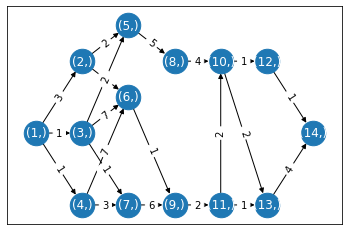

Path from SE contains goal node!
Solution found: (1, 2, 6, 9, 11, 10, 12, 14)


In [7]:
# Define path class to consist of:
# nodes: a list of nodes in the path
# h: the euclidean distance between the last node in the path and the goal node
# F: the heuristic function
# tt_mu: the mean travel time of the path
class Path:
  def __init__(self, nodes, h, F, tt_mu):
    self.nodes = nodes
    self.h = h
    self.F = F
    self.tt_mu = tt_mu

# Returns the last "k" nodes from a path
def get_last_link(path, k):
  link = ()
  for i in range(0,k):
    link = (path.nodes[-1-i],) + link
  return link

# Check dominance of a path
def check_dominance(G, G_cov, p_hat, P_hat_k, alpha, k):
  P_D = []
  nondominated = True
  for i in range(0, len(P_hat_k)):
    if (inv_cdf(G, G_cov, p_hat.nodes, alpha, k) > inv_cdf(G, G_cov, P_hat_k[i].nodes, alpha, k)):
      nondominated = False
    else:
      P_D.append(P_hat_k[i])
  for j in range(0, len(P_D)):
    P_hat_k.remove(P_D[j])
  if len(P_hat_k) == 0:
    P_hat_k.append(p_hat)
  
  return nondominated, P_hat_k, P_D

# Main algorithm
# G: a graph representing a road network
# G_cov: the covariance matrix between the links in the road network
# r: the origin node
# s:the destination node
# alpha: the level of confidence/risk
# k: the spatial influence factor
def sdrsp_ha_star(G, G_cov, r, s, alpha=0.5, k=3):
  # Step 1: Initialization
  Hg = build_Hg(G, k)   # construct the ground hierarchy
  Ht = build_Ht(G, Hg, k)  # construct the top hierarchy
  P = {}    # initialize P_hat_rj (dict)
  tt_mean_sorted = []
  SE = []   # initialize scan eligible set (list)
  F_sorted = []
  hs = calc_euclidean_distance(G, s)  # calculate the heuristic for each node

  origin_border_nodes = get_border_nodes(Hg[list(G.nodes).index(r)], k)  # obtain the border nodes from the tree rooted at the origin
  for border_node in origin_border_nodes:
    for child in list(Ht.successors(border_node)):
      new_path = border_node + tuple(set(child) - set(border_node))
      h = hs[(new_path[-1],)]
      F = inv_cdf(G, G_cov, new_path, alpha, k)
      tt_mean = travel_time_mean(G, new_path)
      new_path_obj = Path(new_path, h, F, tt_mean)
      key = (new_path_obj.nodes[0], new_path_obj.nodes[-1])
      bisect.insort(tt_mean_sorted, tt_mean)
      idx_tt = tt_mean_sorted.index(tt_mean)
      if key in P:
        P[key].insert(idx_tt, new_path_obj)
      else:
        P[key] = [new_path_obj]
      bisect.insort(F_sorted, F)
      idx = F_sorted.index(F)
      SE.insert(idx, new_path_obj)

  while True:
    # Step 2: Path selection
    if (len(SE) == 0):
      print("Scan eligible set is empty! No solution found.")
      break
    curr_path = SE.pop(0)
    if ((curr_path.nodes[-1],) == s):
      print("Path from SE contains goal node!")
      print("Solution found:", curr_path.nodes)
      break

    # Step 3: Path extension
    curr_path_last_link = get_last_link(curr_path,k)
    for child in list(Ht.successors(curr_path_last_link)):
      new_path = curr_path.nodes + tuple(set(child) - set(curr_path.nodes))
      h = hs[(new_path[-1],)]
      F = inv_cdf(G, G_cov, new_path, alpha, k)
      tt_mean = travel_time_mean(G, new_path)
      new_path_obj = Path(new_path, h, F, tt_mean)
      key = (new_path_obj.nodes[0], new_path_obj.nodes[-1])

      # Check dominance
      if key in P:
        nondominated, P[key], P_D = check_dominance(G, G_cov, new_path_obj, P[key], alpha, k)
      else:
        nondominated = True
        P[key] = [new_path_obj]
        P_D = []

      for path_obj in P_D:
        # print_SE(SE)
        if path_obj in SE:
          SE.remove(path_obj) # remove P_D from SE
          F_sorted.remove(path_obj.F)
      if nondominated == True:
        bisect.insort(F_sorted, new_path_obj.F)
        idx = F_sorted.index(new_path_obj.F)
        SE.insert(idx, new_path_obj) # add new_path_obj to SE if nondominated

road_network, road_network_cov = construct_road_network(index=2)
sdrsp_ha_star(road_network, road_network_cov, r=(1,), s=(14,), alpha=0.374, k=3)